In [233]:
"""
Patrick Brosseau 2023/02/24

This notebook compares the performance of linear regression, a neural network without any hidden layers and a 
neural network with a single hidden layer in the problem of spectral pulse shaping.

"""


import numpy as np
from numpy import mean
from numpy import std
from numpy.random import random
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
from scipy.ndimage import gaussian_filter,gaussian_filter1d
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold, train_test_split
import tensorflow as tf
import tensorflow_addons as tfa

from tqdm import tqdm
import glob


def super_gaus(x,a,x0,sigma,order):
    return a*np.exp(-((x-x0)**2/(2*sigma**2))**order)

def Randomwalk1D(n): #n here is the no. of steps that we require
    x = 33
    xposition = [33] #starting from origin (0,0)
    for i in range (1,n+1):
        if xposition[-1] == 65:
            x-=1
        elif xposition[-1] == 0:
            x+=1
        else:            
            step = np.random.uniform(0,1)
            if step < 0.5: # if step is less than 0.5 we move up    
                x -= 1
            if step > 0.5: # if step is greater than 0.5 we move down  
                x += 1
        xposition.append(x)
    return xposition

def shift_spectrum(y,step_num):
    # shift spectrum y by step_num, to simulate calibration shift
    if y.ndim == 1:
        y = np.hstack((np.zeros(10)+0.001,y))
        y = np.hstack((y,np.zeros(10)+0.001))
        shift_spec = y[10-step_num:-10-step_num]
    if y.ndim == 2:
        y = np.hstack((np.zeros((y.shape[0],10))+0.001,y))
        y = np.hstack((y,np.zeros((y.shape[0],10))+0.001))
        shift_spec = y[:,10-step_num:-10-step_num]
    return shift_spec

def pulse_shaper(measured_spectrum,mask,shift=-2):
    # simulates pulse shaper transfer function
    output_spectrum = mask*np.sqrt(shift_spectrum(measured_spectrum,shift))
    return output_spectrum

def generate_ideal_mask(measured_spectrum,goal_spectrum,shift=-2):
    # generates the ideal amplitude mask for a measured spectrum and a goal spectrum
    mask = goal_spectrum/np.sqrt(shift_spectrum(measured_spectrum,shift))
    return mask

In [238]:
def generate_data():
    print("Data generation...")
    
    dat = np.load(r"C:\Users\patri\Documents\LAB\FROG\deepfrog\fiber_spectrum_powerange.npz")
    spectrum_mat_load = dat['spectrum_mat_load'][51::,:]
    
    ev = dat['ev']
    
    exp_len = 100 #Steps in the random walk
    walk = np.random.randint(65, size=(exp_len))#Randomwalk1D(5000)[::10]

    spectrum_mat_random = []
    walk = Randomwalk1D(exp_len)
    for i in range(0,exp_len):
        spectrum_mat_random.append(spectrum_mat_load[walk[i],:])
    spectrum_mat_random = np.array(spectrum_mat_random)

    #Add noise to spectrum after random walk
    noise = 0.1*random((spectrum_mat_random.shape))
    spectrum_mat_random = spectrum_mat_random + noise

    spec_num = spectrum_mat_random.shape[0]#exp_len
    spectrum_mat= spectrum_mat_random
    
    training_full_set = []
    label_full_set = []

    width_num = 10
    center_num = 10
    for center in np.linspace(2.02,2.08,center_num):
        for width in np.linspace(0.03,0.1,width_num):
            goal = super_gaus(ev,1,center,width,2)+0.01
    #             R_mat = generate_ideal_mask(current_spectrum_mat,goal)
            R_mat = goal/np.sqrt(spectrum_mat)   #generate non-ideal mask
            output_mat = pulse_shaper(spectrum_mat,R_mat)
            training_full_set.append(np.hstack((spectrum_mat,output_mat)))
            label_full_set.append(R_mat)   

    training_full_set = np.array(training_full_set)
    training_full_set = np.resize(training_full_set,(spec_num*center_num*width_num,200))
    label_full_set = np.array(label_full_set)
    label_full_set = np.resize(label_full_set,(spec_num*center_num*width_num,100))
    
    print("Data generation complete")
    return [ev,training_full_set,label_full_set,walk]

In [239]:
def train_model(training_full_set, label_full_set,model_type,epochs,plot):
    print("Training...")
    X_train, X_test, y_train, y_test = train_test_split(training_full_set, label_full_set, test_size=0.2, random_state=42)
    n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]
    
    if model_type == "NN_no_layer":
        model = tf.keras.Sequential()
    #     model.add(tf.keras.layers.Dense(100, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
        model.add(tf.keras.layers.Dense(n_outputs))
        model.compile(loss='mse', optimizer='adam',metrics="accuracy")
        history = model.fit(X_train, y_train, verbose=1, epochs=epochs)
        
        if plot:
            plt.figure(figsize=(4,2),dpi=200)
            plt.plot(history.history['accuracy'])
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.hlines(history.history['accuracy'][-1],0,len(history.history['accuracy']),color="k",linestyle="--")
        
    elif model_type == "NN_one_layer":
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(100, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
        model.add(tf.keras.layers.Dense(n_outputs))
        model.compile(loss='mse', optimizer='adam',metrics="accuracy")
        history = model.fit(X_train, y_train, verbose=1, epochs=epochs)
        
        if plot:
            plt.figure(figsize=(4,2),dpi=200)
            plt.plot(history.history['accuracy'])
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.hlines(history.history['accuracy'][-1],0,len(history.history['accuracy']),color="k",linestyle="--")
        
    elif model_type == "LR":
        model = linear_model.LinearRegression()
        model = model.fit(X_train,y_train)
        history = []
    
    print("Training Complete")
    return X_train, X_test, y_train, y_test, model, history

In [264]:
def validate_model(ev,X_train, X_test, y_train, y_test, model,plot,model_type):
    print("Validating...")
    goal_spectrum = super_gaus(ev,1,2.05,0.05,2) #width was 0.1

    test_mat = []
    nonideal_mat = []
    goal_mat = []
    spectrum_mat_test = X_test[0:100,0:100]
    for i in range(0,spectrum_mat_test.shape[0]):
#         goal_mat.append(goal_spectrum)
        goal_mat.append(X_test[i,100::])
        nonideal_mat.append(goal_spectrum/np.sqrt(spectrum_mat_test[i,:]))

        row = np.hstack((spectrum_mat_test[i,:],goal_spectrum))
        newX = np.asarray([row])
        newX = tf.convert_to_tensor(newX)
        if model_type == "NN_no_layer" or model_type == "NN_one_layer":
            R = model.predict(newX,verbose=0)   #predict mask 
        else:
            R = model.predict(newX)
        test_mat.append(pulse_shaper(spectrum_mat_test[i,:],R[0]))
    test_mat = np.array(test_mat)
    goal_mat = np.array(goal_mat)

    seq = np.linspace(0,spectrum_mat_test.shape[0],spectrum_mat_test.shape[0])

    residuals = test_mat-goal_mat
    if plot:
        plt.figure(figsize=(2,1.5),dpi=200)
        plt.plot(ev,goal_spectrum,label="Goal Spec.")
        plt.plot(ev,test_mat[0,:],label="Shaped Spec.")
        plt.legend(fontsize=8)
        plt.xlabel("Energy (eV)")
        plt.ylabel("Intensity (a.u.)")

        plt.figure(figsize=(2,1.5),dpi=200)
        plt.pcolormesh(test_mat,cmap="jet")
        plt.xlabel("Energy (eV)")
        plt.ylabel("Spectrum num.")
        plt.title("Shaped Spec. with ANN mask")

        plt.figure(figsize=(2,1.5),dpi=200)
        plt.pcolormesh(ev,seq,residuals,cmap="seismic",vmin=-0.15,vmax=0.15)
        plt.colorbar()
        plt.xlabel("Energy (eV)")
        plt.ylabel("Spectrum num.")
        plt.title("Residuals")
    
    mse = np.sum(np.abs(residuals)*2)/residuals.shape[0]
    print("Validation Complete")
    return mse

In [265]:
def full_run(model_type,plot_results,epochs):
    print("Testing "+model_type+":")
    ev,training_full_set,label_full_set,_ = generate_data()
#     plt.pcolormesh(training_full_set)
    X_train, X_test, y_train, y_test, model, history = train_model(training_full_set, label_full_set, model_type, epochs,plot_results)
    mse = validate_model(ev,X_train, X_test, y_train, y_test, model,plot_results,model_type)
    return mse

0
Data generation...
Data generation complete
Training...
Training Complete
Validating...
Validation Complete
Training...
Training Complete
Validating...
Validation Complete
Training...
Training Complete
Validating...
Validation Complete


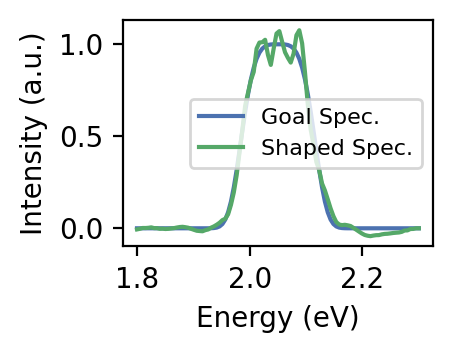

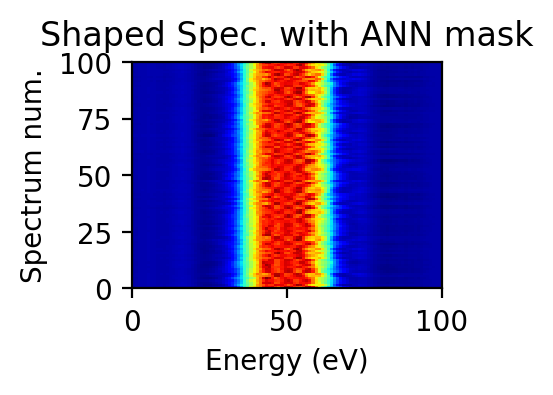

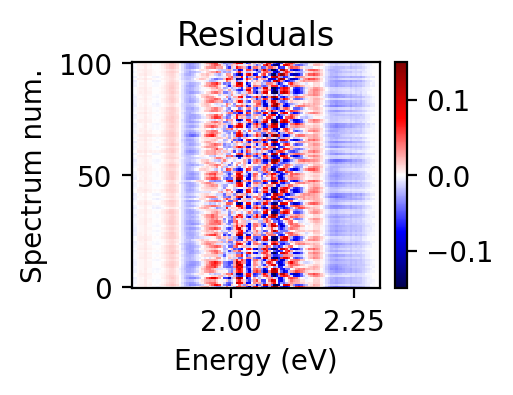

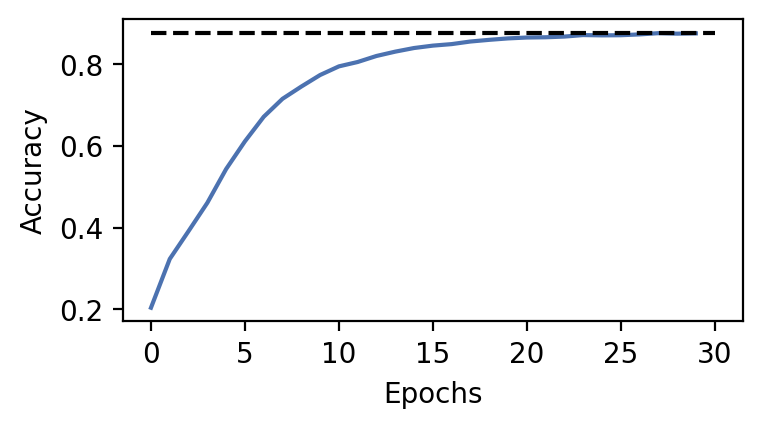

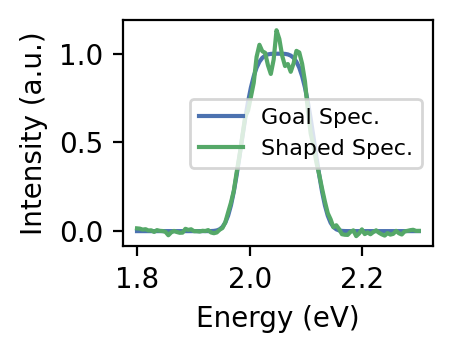

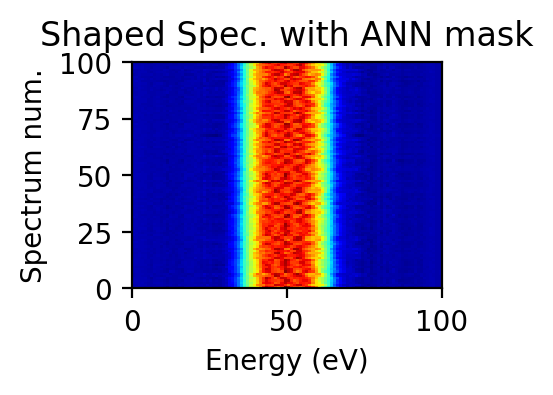

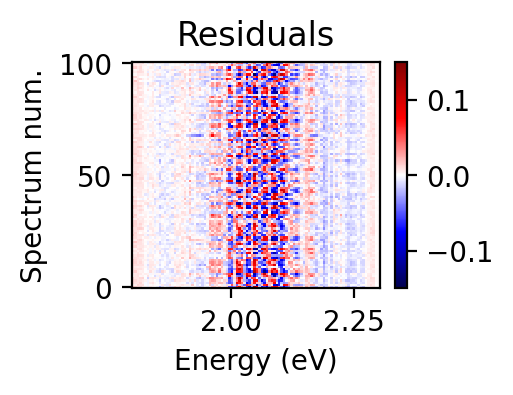

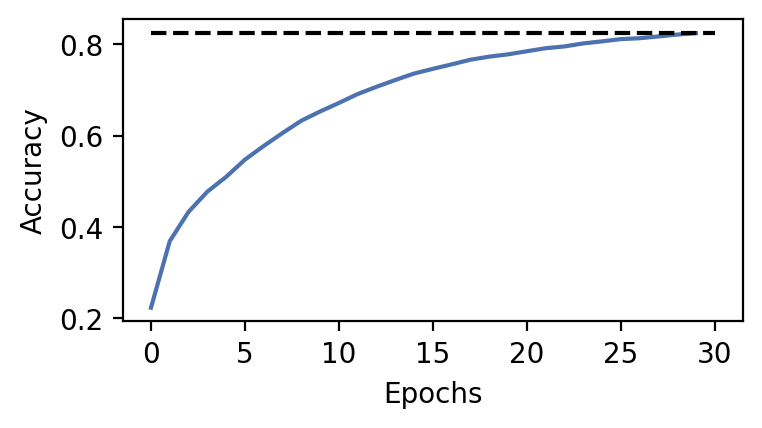

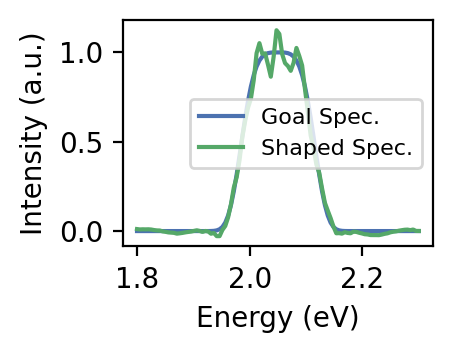

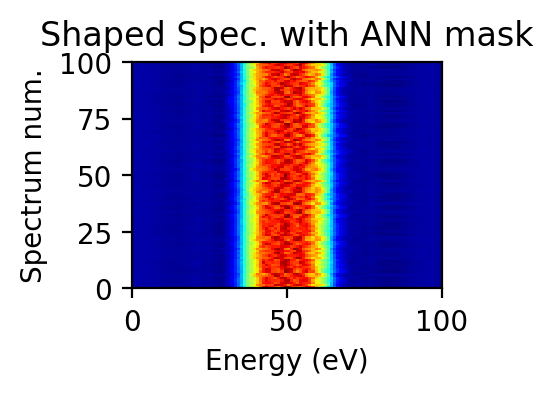

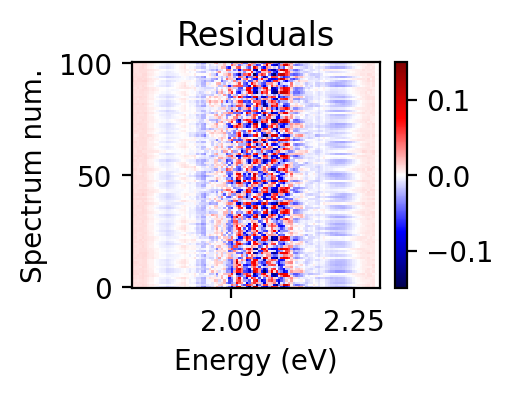

In [216]:
epochs = 30
mse_LR = []
mse_NN_no_layer = []
mse_NN_one_layer = []
walks = []
for i in range(1):
    print(i)
    ev,training_full_set,label_full_set,walk = generate_data()
    walks.append(walk)
    
    model_type = "LR"
    X_train, X_test, y_train, y_test, model, history = train_model(training_full_set, label_full_set, model_type, epochs,plot_results)
    mse = validate_model(ev,X_train, X_test, y_train, y_test, model,plot_results,model_type)
    mse_LR.append(mse)
    
    model_type = "NN_no_layer"
    X_train, X_test, y_train, y_test, model, history = train_model(training_full_set, label_full_set, model_type, epochs,plot_results)
    mse = validate_model(ev,X_train, X_test, y_train, y_test, model,plot_results,model_type)
    mse_NN_no_layer.append(mse)
    
    model_type = "NN_one_layer"
    X_train, X_test, y_train, y_test, model, history = train_model(training_full_set, label_full_set, model_type, epochs,plot_results)
    mse = validate_model(ev,X_train, X_test, y_train, y_test, model,plot_results,model_type)
    mse_NN_one_layer.append(mse)